In [1]:
from mundilib import MundiCatalogue
from utils import height2width
from PIL import Image
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [101]:
c = MundiCatalogue()
wms = c.get_collection("Sentinel2").mundi_wms('L1C')

In [109]:
img = wms.getmap(layers=["5_VEGETATION_INDEX"],
                     srs='EPSG:3857',
                     bbox=(752904.7286,5826183.1700,819252.0692,5871128.1426), # Toulouse
                     size=(1476, 1000),
                     format='image/png',
                     time='2022-03-21/2022-04-21',
                     showlogo=False,
                     transparent=False)
data = Image.open(img)
display(data)
data.save("forfilip.png")

ServiceException: <?xml version='1.0' encoding="UTF-8" standalone="no" ?>
<!DOCTYPE ServiceExceptionReport SYSTEM
 "http://schemas.opengis.net/wms/1.1.1/WMS_MS_Capabilities.dtd">
<ServiceExceptionReport version="1.1.1">
	<ServiceException code="LayerNotDefined">
		<![CDATA[ Layer 5_VEGETATION_INDEX not found ]]>
	</ServiceException>
</ServiceExceptionReport>

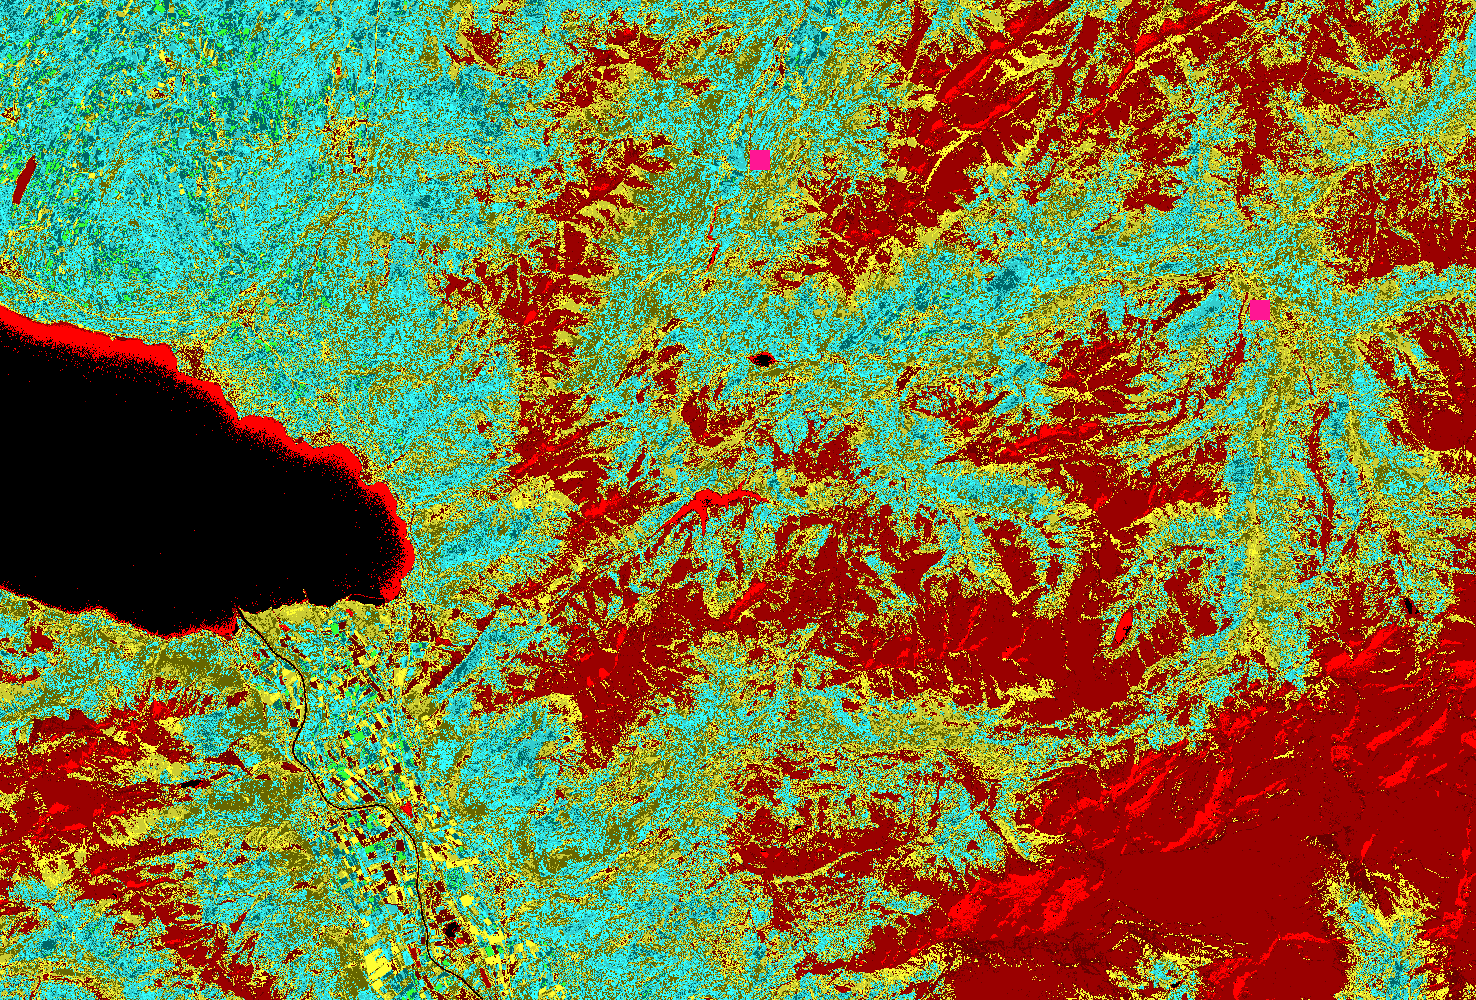

In [98]:
# TWO PHOTOS FOR PRESENTATION
import math
def lineover(img,pixelCords, init,end):
    
    img_array = np.asarray(Image.open(img))
    pixelsmap = img_array.copy()
    x = int(math.ceil(pixelCords[0]))
    y = int(math.ceil(pixelCords[1]))
  
#     pixelsmap[x:x+20,y:y+20][:] = [255, 22, 148,255]
    
    
    pixelsmap[init[0]:init[0]+20,init[1]:init[1]+20][:] = [255, 22, 148,255]
    pixelsmap[end[0]:end[0]+20,end[1]:end[1]+20][:] = [255, 22, 148, 255]
    
    photo = Image.fromarray(pixelsmap)
    display(photo)
    photo.save("second.png")

pixEnd = (300, 1250)
pixInit = (150,750)

lineover(img,pixInit,pixInit,pixEnd)

In [28]:
# end route
lineover(img,pixEnd)

In [91]:
## FIND THE WAY
import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

grp = nx.Graph()
height = 999
width = 1475

# WATER = 0
# VEGETATION = 1
# DIRT = 2
# MOUNTAINS = 3
# ICE = 4

SCL_WATER_CostArray = np.matrix(
    [
        [100, 100],
        [100, 0],
    ]
)

SCLCostArray = np.matrix(
    [
        [100, 100, 100, 100, 100, 100, 100],
        [100, 0, 10, 50, 40, 40, 20],
        [100, 10, 0, 40, 30, 30, 15],
        [100, 50, 40, 40, 50, 40, 50],
        [100, 40, 30, 50, 90, 90, 40],
        [100, 40, 30, 40, 90, 50, 40],
        [100, 20, 15, 50, 40, 40, 15]
    ]
)

HeightCostArray = np.matrix(
    [
        [0, 50, 100],
        [50, 50, 100],
        [100, 100, 100]
    ]
)

# SCLCostArray = np.matrix([[100, 100, 100, 90, 100],[100, 10, 40, 40, 100],[100, 40, 0, 80, 70],[90, 10, 80, 90, 100],[100, 100, 70, 100, 80]])
# SCLCostArray = np.matrix([[80, 60, 0, 100, 100],[100, 10, 0, 90, 100],[80, 40, 0, 100, 80],[90, 40, 0, 90, 100],[100, 0, 0, 100, 80]])

def calculateVertCost(pos1, pos2):
    return pow(abs(pos1 - pos2),12)

def getCost(pos1, pos2, filterType):
    if not callable(filterType):
        return filterType[pos1, pos2]
    return filterType(pos1, pos2)

def changeEdgeWeight(grp, n1, n2, n1Terrain, n2Terrain, filterType):
    oldWeight = grp.get_edge_data(n1, n2)["weight"]
    grp.add_edge(n1, n2, weight = oldWeight + getCost(n1Terrain,n2Terrain, filterType))

def updateWeights(grp, weigthArray, filterType):
    for i in range(0, height + 1):
        for j in range(0,width + 1):
            if i > 0:
                changeEdgeWeight(grp, str(i) + ' ' + str(j), str(i - 1) + ' ' + str(j), weigthArray[i][j], weigthArray[i - 1][j], filterType)
            if j < width:
                changeEdgeWeight(grp, str(i) + ' ' + str(j), str(i) + ' ' + str(j + 1), weigthArray[i][j], weigthArray[i][j + 1], filterType)

def generateGraph(grp):
    for i in range(0,height + 1):
        for j in range(0,width + 1):
            grp.add_node(str(i) + ' ' + str(j), layer = j)
            if i > 0:
                grp.add_edge(str(i) + ' ' + str(j), str(i - 1) + ' ' + str(j), weight = 0)
    #            if j < width:
    #                grp.add_edge(str(i) + str(j), str(i - 1) + str(j + 1), weight=random.randint(0, 101))
            if j < width:
                grp.add_edge(str(i) + ' ' + str(j), str(i) + ' ' + str(j + 1), weight = 0)
    #            if i < height:
    #                grp.add_edge(str(i) + str(j), str(i + 1) + str(j + 1), weight=random.randint(0, 101))
    return grp

def printGraph(grp):
    elarge = [(u, v) for (u, v, d) in grp.edges(data=True) if d["weight"] > 50]
    esmall = [(u, v) for (u, v, d) in grp.edges(data=True) if d["weight"] <= 50]

    pos = nx.multipartite_layout(grp, subset_key="layer")  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(grp, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(grp, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        grp, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(grp, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(grp, "weight")
    nx.draw_networkx_edge_labels(grp, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def dist(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x2-x1) + abs(y2-y1)

def getAStarPath(grp, pix1x, pix1y, pix2x, pix2y):
    tic = time.perf_counter()
    pathList = nx.astar_path(grp, str(pix1x) + ' ' + str(pix1y), str(pix2x) + ' ' + str(pix2y), weight='weight')
    pathPixPos = []
    for pix in pathList:
        temp = pix.split()
        pathPixPos.append((int(temp[0]), int(temp[1])))
    pathCostLis = []
    for n in range(0, len(pathList) - 1):
        pathCostLis.append(grp.get_edge_data(pathList[n], pathList[n + 1])["weight"])
    toc = time.perf_counter()
    print(f"Path found in {toc - tic:0.4f} seconds")
    return((pathPixPos, pathCostLis))

def getWeightArrayFromTxt(path):
    f = open(path, "r")
    weightArr = np.genfromtxt(path,dtype = int, delimiter=',')

    return weightArr


# testArray = np.random.randint(5, size=(height + 1,width + 1))
# print(testArray)
# testArray2 = np.random.randint(5, size=(height + 1,width + 1))
# print(testArray2)

tic = time.perf_counter()
grp = generateGraph(grp)
toc = time.perf_counter()
updateWeights(grp, getWeightArrayFromTxt("work/SCL.txt"), SCLCostArray)
updateWeights(grp, getWeightArrayFromTxt("work/SCL-WATER-ONLY.txt"), SCL_WATER_CostArray)
# updateWeights(grp, getWeightArrayFromTxt("work/elevation.txt"), calculateVertCost)
updateWeights(grp, getWeightArrayFromTxt("work/HEIGHT_INDEX.txt"), HeightCostArray)

# updateWeights(grp, testArray2, SCLCostArray)
print(f"Graph generated in {toc - tic:0.4f} seconds")

#print(nx.astar_path(grp, '00', '99'))
routeData = getAStarPath(grp, 150, 750, 300, 1250)
print(routeData)



Graph generated in 11.6465 seconds
Path found in 5.4084 seconds
([(150, 750), (151, 750), (151, 749), (151, 748), (151, 747), (151, 746), (151, 745), (151, 744), (151, 743), (151, 742), (151, 741), (151, 740), (151, 739), (151, 738), (151, 737), (151, 736), (152, 736), (153, 736), (154, 736), (155, 736), (156, 736), (157, 736), (158, 736), (159, 736), (160, 736), (161, 736), (162, 736), (163, 736), (164, 736), (165, 736), (166, 736), (167, 736), (168, 736), (169, 736), (170, 736), (170, 735), (171, 735), (172, 735), (173, 735), (174, 735), (175, 735), (176, 735), (177, 735), (178, 735), (179, 735), (180, 735), (181, 735), (182, 735), (183, 735), (184, 735), (185, 735), (186, 735), (186, 734), (186, 733), (187, 733), (187, 732), (187, 731), (188, 731), (189, 731), (190, 731), (191, 731), (192, 731), (193, 731), (194, 731), (195, 731), (196, 731), (197, 731), (198, 731), (199, 731), (200, 731), (201, 731), (202, 731), (203, 731), (204, 731), (205, 731), (206, 731), (207, 731), (208, 731)

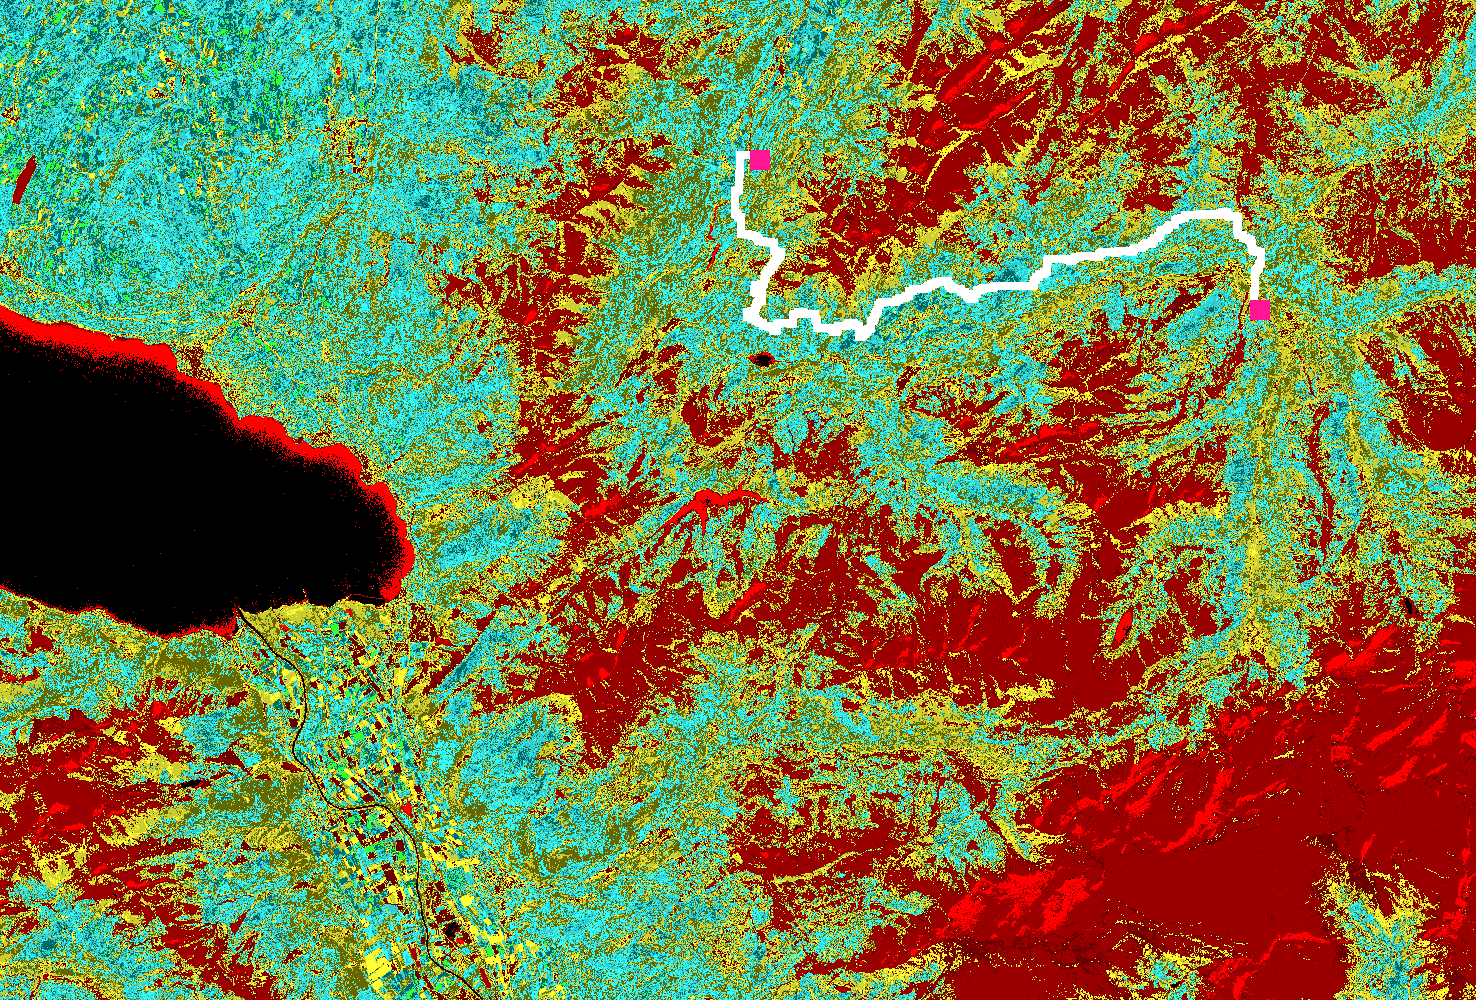

AttributeError: 'NoneType' object has no attribute 'save'

In [110]:
def way(img,pixelArray,init,end):
    
    img_array = np.asarray(Image.open(img))
    pixelsmap = img_array.copy()
    
    numpyArray = np.array(pixelArray)
    
    for x in pixelArray:
        pixelsmap[x[0]:x[0]+8, x[1]:x[1]+8][:] =[0,0,0,0]
  
    pixelsmap[init[0]:init[0]+20,init[1]:init[1]+20][:] = [255, 22, 148,255]
    pixelsmap[end[0]:end[0]+20,end[1]:end[1]+20][:] = [255, 22, 148, 255]
    
    
    pict = Image.fromarray(pixelsmap)
    display(pict)
    
end_data = way(img,routeData[0],pixInit,pixEnd)
end_data.save("end_data.png")

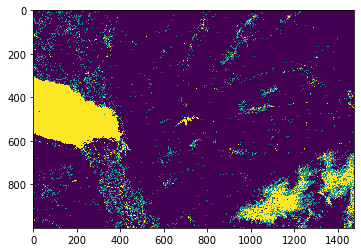

In [88]:
text = np.loadtxt("work/HEIGHT_INDEX.txt",delimiter = ",")
plt.imshow(text, interpolation='nearest')
plt.show()
